In [ ]:
'''
Credit goes to Mr. Georgio for creating the very helpful modules used in this file.
'''

In [2]:
from pyscf import gto,scf
import numpy as np
import pyscf
import matplotlib.pyplot as plt
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
def generate_table(data):
    # Determine the maximum width of each column
    column_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]

    # Generate the table header
    table = generate_table_row(data[0], column_widths)
    table += generate_table_row(['-' * width for width in column_widths], column_widths)

    # Generate the table rows
    for row in data[1:]:
        table += generate_table_row(row, column_widths)

    return table

def generate_table_row(row_data, column_widths):
    row = '|'
    for i, item in enumerate(row_data):
        row += f' {str(item):{column_widths[i]}} |'
    row += '\n'
    return row

In [3]:
%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

#### Verifying electronic energy curve

In [4]:
# def calc_elec_energy(separation):
#     mol = gto.M(atom= f"N 0 0 0; N 0 0 {separation}",unit="Bohr",basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[5,6,7,8,9]))
#     mol_conv= scf.RHF(mol)
#     return mol_conv.scf(dm0=mol_conv.init_guess_by_1e()) - 7*7/separation

In [5]:
# x = 0
# distances = []
# energies = []
# while x < 3:
#     distances.append(x)
#     energies.append(calc_elec_energy(x))
#     x+= 0.3
# plt.plot(distances, energies)

### Defining my molecules

In [7]:
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis=bse.get_basis('unc-ccpvdz',fmt='guassian09', elements=[5,6,7,8]))
CO = FcM_like(NN,fcs=[-1,1])
BF = FcM_like(NN,fcs=[-2,2])
mol_NN = scf.RHF(NN)
mol_CO= scf.RHF(CO)
mol_BF= scf.RHF(BF)

Te_NN=mol_NN.scf(dm0=mol_NN.init_guess_by_1e())
Te_CO=mol_CO.scf(dm0=mol_CO.init_guess_by_1e())
Te_BF=mol_BF.scf(dm0=mol_BF.init_guess_by_1e())

KeyError: 'Basis set unc-ccpvdz does not exist'

In [ ]:
# Subtracting nuclear repulsion from total energy to calculate total electronic energy
e_NN = Te_NN - np.prod(NN.atom_charges()) / d
e_CO = Te_CO - np.prod(CO.atom_charges()) / d
e_BF = Te_BF - np.prod(BF.atom_charges()) / d
print(e_NN, e_CO, e_BF)

-132.2850419029842 -133.76761842584608 -138.63212532845867


## Calculating their energies

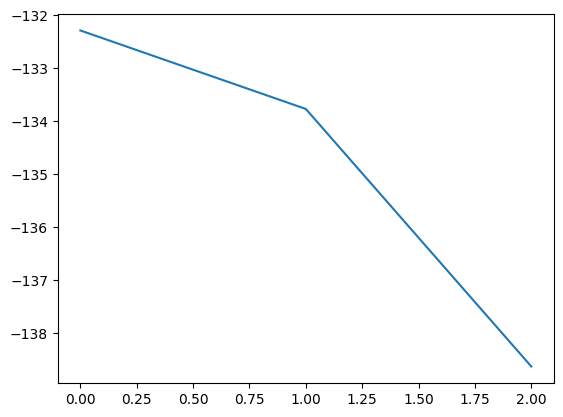

In [247]:
plt.plot([e_NN, e_CO, e_BF])

In [248]:
def d_Z_lambda(mol_i, mol_f,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    e = 7/3
    num = (3/7)* (Z_f**e - Z_i**e)
    den = ((Z_i**e) + lam*(Z_f**e - Z_i**e))**(4/7)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

### Gradients from NN to CO and BF

In [249]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_NN=AP(mol_NN,sites=[0,1])
AG_NN = ap_NN.build_gradient()  - np.array([NN.atom_charges()[1],NN.atom_charges()[0]]) / d 

# calculating linear and non-linear energy gradients
nl_grad_NN_to_CO = np.dot(Z_diff(NN, CO), AG_NN)
l_grad_NN_to_CO = np.dot(d_Z_lambda(NN,CO,lam), AG_NN)

nl_grad_NN_to_BF = np.dot(Z_diff(NN, BF), AG_NN)
l_grad_NN_to_BF = np.dot(d_Z_lambda(NN,BF,lam), AG_NN)

### Gradients from CO to NN and BF

In [250]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_CO=AP(mol_CO,sites=[0,1])
AG_CO = ap_CO.build_gradient() - np.array([CO.atom_charges()[1],CO.atom_charges()[0]]) / d 

# calculating linear and non-linear energy gradients
nl_grad_CO_to_NN = np.dot(Z_diff(CO, NN), AG_CO)
l_grad_CO_to_NN = np.dot(d_Z_lambda(CO,NN,lam), AG_CO)

nl_grad_CO_to_BF = np.dot(Z_diff(CO, BF), AG_CO)
l_grad_CO_to_BF = np.dot(d_Z_lambda(CO,BF,lam), AG_CO)

In [251]:
AG_CO

array([-20.00310304, -23.02708374])

In [252]:
nl_grad_CO_to_NN, l_grad_CO_to_NN, nl_grad_CO_to_BF, l_grad_CO_to_BF

(3.023980699739141,
 -1.1303530154854458,
 -3.023980699739141,
 -7.149219129863054)

### Gradients from BF to CO and NN

In [253]:
# Evaluating the linearized energy gradient at lambda = 0
lam = 0

ap_BF=AP(mol_BF,sites=[0,1])
AG_BF = ap_BF.build_gradient() - np.array([BF.atom_charges()[1],BF.atom_charges()[0]]) / d 

# calculating linear and non-linear energy gradients
nl_grad_BF_to_NN = np.dot(Z_diff(BF, NN), AG_BF)
l_grad_BF_to_NN = np.dot(d_Z_lambda(BF,NN,lam), AG_BF)

nl_grad_BF_to_CO = np.dot(Z_diff(BF, CO), AG_BF)
l_grad_BF_to_CO = np.dot(d_Z_lambda(BF,CO,lam), AG_BF)

In [254]:
nl_grad_BF_to_NN, l_grad_BF_to_NN, nl_grad_BF_to_CO, l_grad_BF_to_CO

(13.917192879015317, -2.7584204134583654, 6.958596439507659, 2.813085654368475)

In [255]:
nl_grads= np.array([nl_grad_CO_to_NN, nl_grad_CO_to_BF,
                    nl_grad_BF_to_NN, nl_grad_BF_to_CO])

l_grads= np.array([l_grad_CO_to_NN, l_grad_CO_to_BF,
                    l_grad_BF_to_NN, l_grad_BF_to_CO])

# nl_grads = np.append(nl_grads,[nl_grad_NN_to_BF, nl_grad_NN_to_CO])
# l_grads = np.append(l_grads,[l_grad_NN_to_BF, l_grad_NN_to_CO])


## getting average linearizing coeffecient = ratio of nl_grad to l_grad

In [256]:
C = np.mean(l_grads / nl_grads)

In [260]:
NN_pred = ['NN','-', e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF]
CO_pred = ['CO',e_CO + C *nl_grad_CO_to_NN,'-' ,  e_CO + C *nl_grad_CO_to_BF]
BF_pred = ['BF',e_BF + C *nl_grad_BF_to_NN,e_BF + C *nl_grad_BF_to_CO,'-' ]

# finding nl_E predictions
# NN_pred = 


In [261]:
# Example usage
data = [
    ['From \ To', 'NN', 'CO','BF'],
    ['NN','-', e_NN + C *nl_grad_NN_to_CO ,  e_NN + C *nl_grad_NN_to_BF],
    ['CO',e_CO + C *nl_grad_CO_to_NN,'-' ,  e_CO + C *nl_grad_CO_to_BF],
    ['BF',e_BF + C *nl_grad_BF_to_NN,e_BF + C *nl_grad_BF_to_CO,'-' ]
]
table = generate_table(data)

print(table)
print(f'NN actual energy = {e_NN}, \nCO actual energy = {e_CO}, \nBF actual energy = {e_BF}, \n')

| From \ To | NN                  | CO                  | BF                  |
| --------- | ------------------- | ------------------- | ------------------- |
| NN        | -                   | -132.28504190298432 | -132.28504190298443 |
| CO        | -132.1071229367535  | -                   | -135.42811391493865 |
| BF        | -130.99006729600177 | -134.8110963122302  | -                   |

NN actual energy = -132.2850419029842, 
CO actual energy = -133.76761842584608, 
BF actual energy = -138.63212532845867, 



### Without using N2 gradients
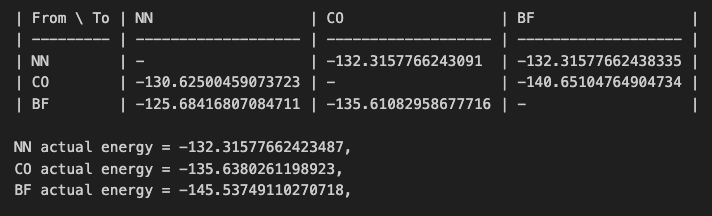

In [279]:
#!/usr/bin/env python
import os
import numpy
from pyscf import gto

mol = gto.M(
    atom = '''N 0 0 0; N 0 0 2''',
    basis = 
    {'N': 'unc-ccpvdz', # prefix "unc-" will uncontract the ccpvdz basis.
                                # It is equivalent to assigning
                                #   'O': gto.uncontract(gto.load('ccpvdz', 'O')),
             'H': 'unc-ccpvdz'  # H1 H2 will use the same basis ccpvdz
            }
)